In [145]:
import glob
import pandas as pd
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:,.2f}'.format
import numpy as np
import tqdm
import os
import plotly.graph_objs as go
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns


In [146]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

In [147]:
# df = pd.read_csv('../data/nq5years2h.csv')
dfext = pd.read_csv( '../data/nq_ext.csv', skiprows=2, names=['price', 'target'] )

In [148]:
llstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)


In [155]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, max_labels, seq_len=15):
        self.data = data
        self.seq_len = seq_len
        self.max_labels = max_labels
        
    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_len]
        y = self.max_labels[idx+self.seq_len-1]
#         print(x)
        scaler = MinMaxScaler()
        x = scaler.fit_transform(x.reshape((-1,1))).reshape((-1,))
#         print('ADASDASDASD')
#         print(x)
#         print(y)
#         raise 'asd'
        return x, y
    
    def __len__(self):
        return len(self.data) - self.seq_len

class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out.squeeze()


In [156]:
# Load data
data = dfext.price.values.astype('float32') # Your time series data as a numpy array or torch tensor
max_labels = dfext.target.values.astype('float32') # Your labels for local maximum points as a numpy array or torch tensor

In [157]:
# Create train and test datasets
train_data = TimeSeriesDataset(data[:6000], max_labels[:6000])
test_data = TimeSeriesDataset(data[6000:], max_labels[6000:])

# Create dataloaders
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [158]:
# Initialize model
input_size = 1 # NASDAQ 100 index is a univariate time series
hidden_size = 64 # Number of hidden units in LSTM
num_layers = 1 # Number of LSTM layers
lstm = LSTM(input_size, hidden_size, num_layers)

print(lstm)

LSTM(
  (lstm): LSTM(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
    print(batch_idx)
    print(x_batch.tolist())
    print(y_batch.tolist())
    break

In [159]:
# Set training parameters
learning_rate = 0.001
num_epochs = 50
criterion = nn.BCEWithLogitsLoss() # Binary cross-entropy loss with logits
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Train model
for epoch in range(num_epochs):
    lstm.train()
    for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
        x_batch = x_batch.unsqueeze(-1) # Add input_size dimension
#         print(y_batch.shape)
#         break
        y_pred = lstm(x_batch)
        loss = criterion(y_pred, y_batch.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate model on test set
    lstm.eval()
    with torch.no_grad():
        test_loss = 0
        for x_test, y_test in test_loader:
            x_test = x_test.unsqueeze(-1) # Add input_size dimension
            y_pred = lstm(x_test)
            test_loss += criterion(y_pred, y_test.float()).item()
        test_loss /= len(test_loader)
        
    print(f'Epoch {epoch+1}/{num_epochs}: Train Loss={loss.item():.4f}, Test Loss={test_loss:.4f}')

Epoch 1/50: Train Loss=0.1367, Test Loss=0.1476
Epoch 2/50: Train Loss=0.0414, Test Loss=0.1476
Epoch 3/50: Train Loss=0.2406, Test Loss=0.1468
Epoch 4/50: Train Loss=0.2314, Test Loss=0.1462
Epoch 5/50: Train Loss=0.4008, Test Loss=0.1480
Epoch 6/50: Train Loss=0.3418, Test Loss=0.1446
Epoch 7/50: Train Loss=0.1337, Test Loss=0.1428
Epoch 8/50: Train Loss=0.1258, Test Loss=0.1399
Epoch 9/50: Train Loss=0.1991, Test Loss=0.1365
Epoch 10/50: Train Loss=0.0296, Test Loss=0.1348
Epoch 11/50: Train Loss=0.1210, Test Loss=0.1299
Epoch 12/50: Train Loss=0.1344, Test Loss=0.1294
Epoch 13/50: Train Loss=0.0418, Test Loss=0.1293
Epoch 14/50: Train Loss=0.1237, Test Loss=0.1308
Epoch 15/50: Train Loss=0.1132, Test Loss=0.1278
Epoch 16/50: Train Loss=0.0276, Test Loss=0.1296
Epoch 17/50: Train Loss=0.1964, Test Loss=0.1278
Epoch 18/50: Train Loss=0.0392, Test Loss=0.1289
Epoch 19/50: Train Loss=0.0536, Test Loss=0.1277
Epoch 20/50: Train Loss=0.2291, Test Loss=0.1293
Epoch 21/50: Train Loss=0.294

In [160]:
# Predict using trained model
def predict_max(data_point, model, seq_len=15):
    
    model.eval()
    with torch.no_grad():
#         data_point = torch.tensor(data_point).float()
        data = torch.tensor(data_point, dtype=torch.float32)

        # Add batch size and input size dimensions
        data = data.unsqueeze(-1)
#         print(data)
#         return
        # Pass the data through the model
        out = model(data)

        # Squeeze the output to remove the batch size and hidden dimensions
        out = out.squeeze()

        # Apply the sigmoid function to get a probability value between 0 and 1
        prob = torch.sigmoid(out)

        # Threshold the probability at 0.5 to get a binary prediction
        pred = (prob >= 0.5).float()

        # Convert the prediction to a Python scalar and return it
        return pred

def evaluate(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            output = model(X_batch)
            output = (output > threshold).int()
            y_pred.extend(output.tolist())
            y_true.extend(y_batch.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
    
    
best_model = MinMaxClassifier(numer_of_features, hidden_size, num_layers, out_size, lr).to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/model.pt', best_model, optimizer)
evaluate(best_model, test_loader)

In [161]:
import sys


/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a

Classification Report:
              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000        43
           0     0.9672    1.0000    0.9833      1267

    accuracy                         0.9672      1310
   macro avg     0.4836    0.5000    0.4917      1310
weighted avg     0.9354    0.9672    0.9510      1310



/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a

[Text(0, 0.5, 'Max'), Text(0, 1.5, 'Not max')]

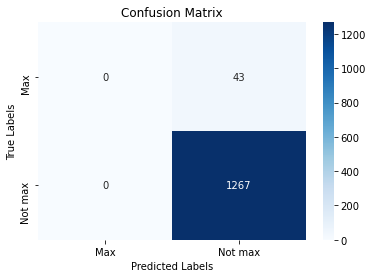

In [162]:
y_pred = []
y_true = []
for batch_idx, (x_batch, y_batch) in enumerate(test_loader):
    output = predict_max(x_batch, lstm)
    y_pred.extend(output.tolist())
    y_true.extend(y_batch.tolist())

print('Classification Report:')
print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

cm = confusion_matrix(y_true, y_pred, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

ax.set_title('Confusion Matrix')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

ax.xaxis.set_ticklabels(['Max', 'Not max'])
ax.yaxis.set_ticklabels(['Max', 'Not max'])
    
    